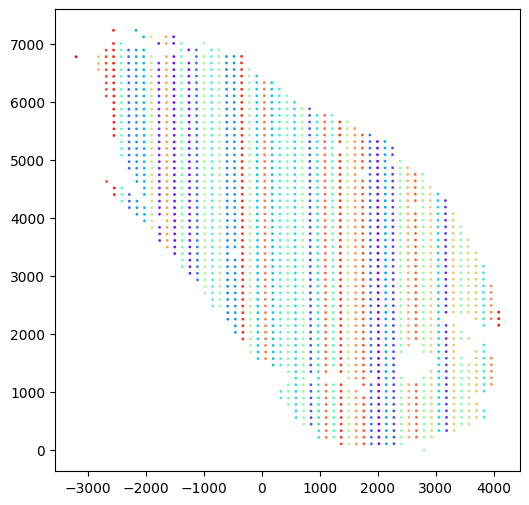

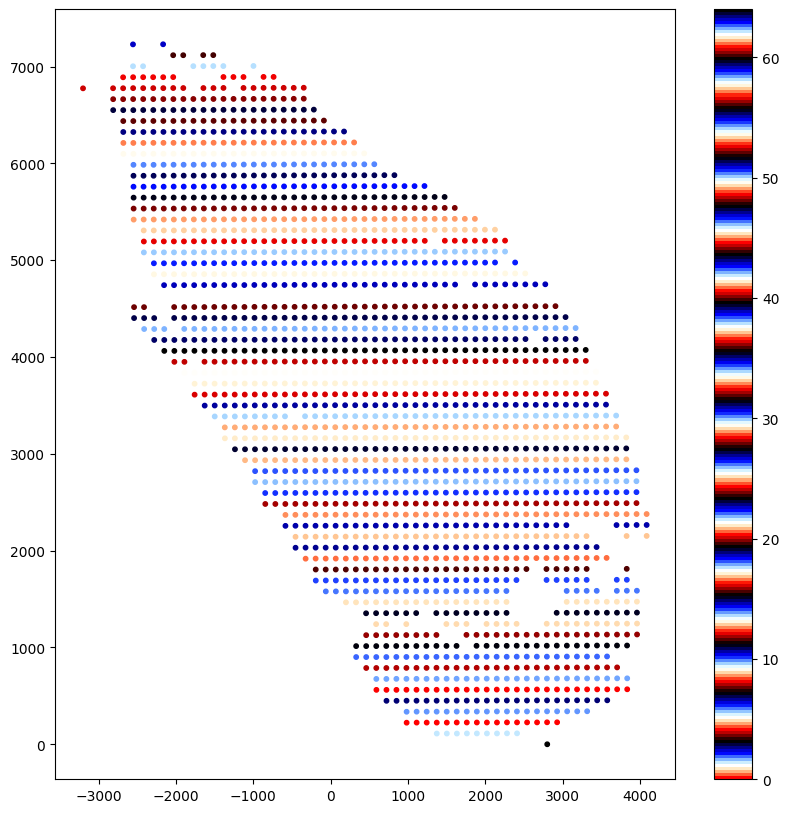

In [264]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import hough_line, hough_line_peaks
import numpy as np

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line as draw_line
from skimage import data

import matplotlib.pyplot as plt
from matplotlib import cm

df = pd.read_csv('SpotPositions_SP2.csv')

df['hex_x'] = np.array(df.x - (np.sqrt(3)/3) * df.y)
df['hex_y'] = np.array(df.y )
X = np.array([df.hex_x, df.hex_y])

# Can we just cluster in the x and y axes separately?

# plt.hist(X[0],bins = 100)
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=40, min_samples=1).fit(X[0].reshape(-1,1))
x_labels= db.labels_

# plt.plot(labels)
plt.figure(figsize = (6,6))
plt.scatter(df.hex_x,df.hex_y, c=x_labels, cmap='rainbow', s = 1)

db = DBSCAN(eps=40, min_samples=1).fit(X[1].reshape(-1,1))
y_labels= db.labels_

# plt.plot(labels)
plt.figure(figsize = (10,10))
plt.scatter(df.hex_x,df.hex_y, c=y_labels, cmap='flag', s = 10)
plt.colorbar()


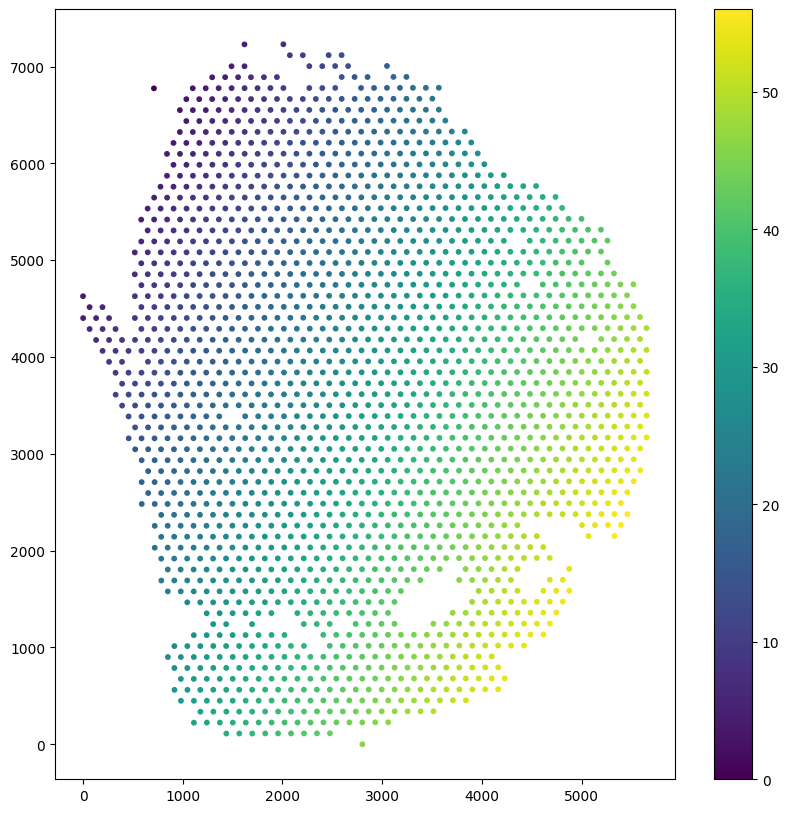

In [292]:

df['x_labels_dbscan'] = x_labels
df['y_labels_dbscan'] = y_labels

# now we want to use these labels to place the points within a grid
df['group_x'] = df.groupby('x_labels_dbscan')['hex_x'].transform('mean')
df['group_y'] = df.groupby('y_labels_dbscan')['hex_y'].transform('mean')

# add some kind of warning here if std deviation is too high due to lots of gaps in the grid?
#  disable zoom scaling if this is the case?
x_dists = np.diff(np.sort(np.unique(df.group_x)))
y_dists = np.diff(np.sort(np.unique(df.group_y)))
mean_x_dist = np.mean(x_dists)
mean_y_dist = np.mean(y_dists)

recalc_x_dists = x_dists[np.abs(x_dists - mean_x_dist) < (mean_x_dist / 2)]
recalc_y_dists = y_dists[np.abs(y_dists - mean_y_dist) < (mean_y_dist / 2)]
recalc_mean_x_dist = np.mean(recalc_x_dists)
recalc_mean_y_dist = np.mean(recalc_y_dists)

# plt.plot(x_dists)
# plt.axhline(mean_x_dist)

# plt.plot(recalc_x_dists)
# plt.axhline(recalc_mean_x_dist)

# now we have our grid spacing, how do we choose a zero point
xmin = np.min(df.group_x)
xmax = np.max(df.group_x)
ymin = np.min(df.group_y)
ymax = np.max(df.group_y)

n_x = int(np.abs(xmax - xmin) // recalc_mean_x_dist) + 2
n_y = int(np.abs(ymax - ymin) // recalc_mean_y_dist) + 1

gridlines_x = df.group_x.min() + np.arange(0, n_x) * recalc_mean_x_dist
gridlines_y = df.group_y.min() + np.arange(0, n_y) * recalc_mean_y_dist


for i,row in df.iterrows():
    x_grid_ix = np.argmin(np.abs(gridlines_x - row.group_x))
    y_grid_ix = np.argmin(np.abs(gridlines_y - row.group_y))
    df.loc[i,'grid_x'] = x_grid_ix
    df.loc[i,'grid_y'] = y_grid_ix

plt.figure(figsize = (10,10))
plt.scatter(df.x,df.y, c=df.grid_x, s = 10)
plt.colorbar()



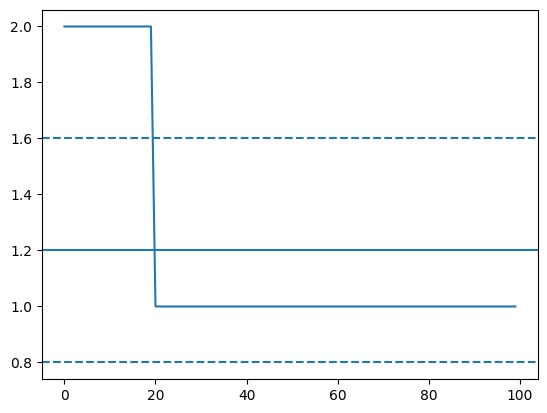

In [295]:
aa = np.ones(100)

aa[:20] = 2

plt.plot(aa)
plt.axhline(np.mean(aa))
plt.axhline(np.mean(aa) - np.std(aa), ls=  '--')
plt.axhline(np.mean(aa) + np.std(aa), ls=  '--')


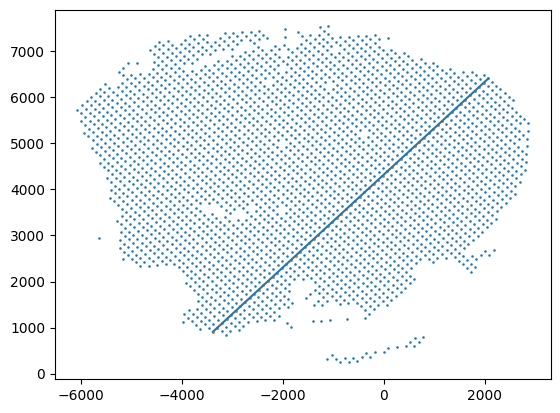

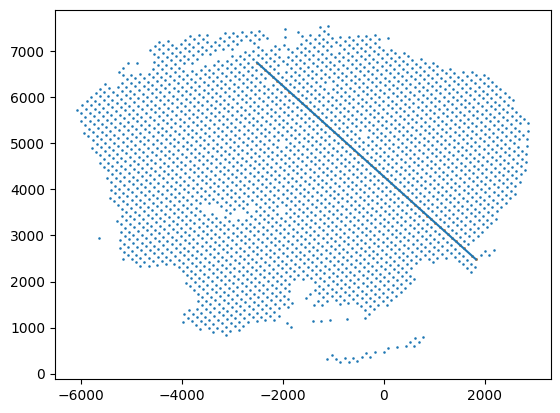

[-9.92344729e-01  1.84998149e+07]


In [191]:
# Check the points are rotated not skewed
X = np.array([hex_i, hex_j])

def rotation_matrix(theta):
  return np.array(
      (
          [np.cos(theta),-np.sin(theta)],
          [np.sin(theta),np.cos(theta)]
      )
  )
R = rotation_matrix(np.pi/4)
Xrot = np.matmul(R,X)

j_mask = (hex_j > 3000) & (hex_j <3100)
i_mask = (hex_i > 3000) & (hex_i <3100)

plt.figure()

def fit_line(x,y,mask,plot = True):
  # fit line of constant j coord

  z = np.polyfit(x[mask],y[mask],1)
  # plt.xlim(2000,4000)
  # plt.ylim(2000,4000)

  x_vals = np.linspace(np.max(x[mask]), np.min(x[mask]), 100)
  y_vals = np.polyval(z,x_vals)
  if plot:
    plt.scatter(x, y, s=  0.7)
    plt.scatter(x[mask], y[mask], s=  0.9)
    plt.plot(x_vals, y_vals)
    plt.show()
  return z, x_vals,y_vals


z_j = fit_line(Xrot[0],Xrot[1],j_mask)
z_i = fit_line(Xrot[0],Xrot[1],i_mask)

print(z_i[0] * z_j[0])


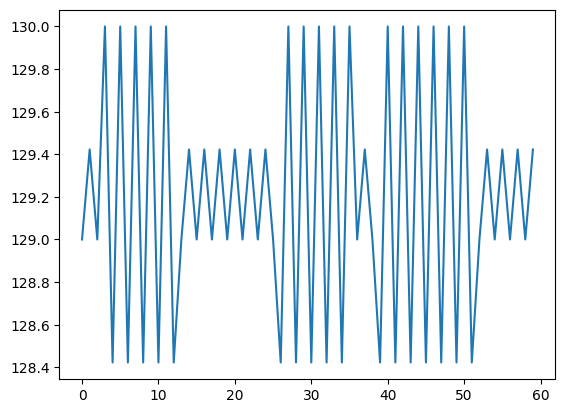

Text(0.5, 1.0, 'Y axis coordinates')

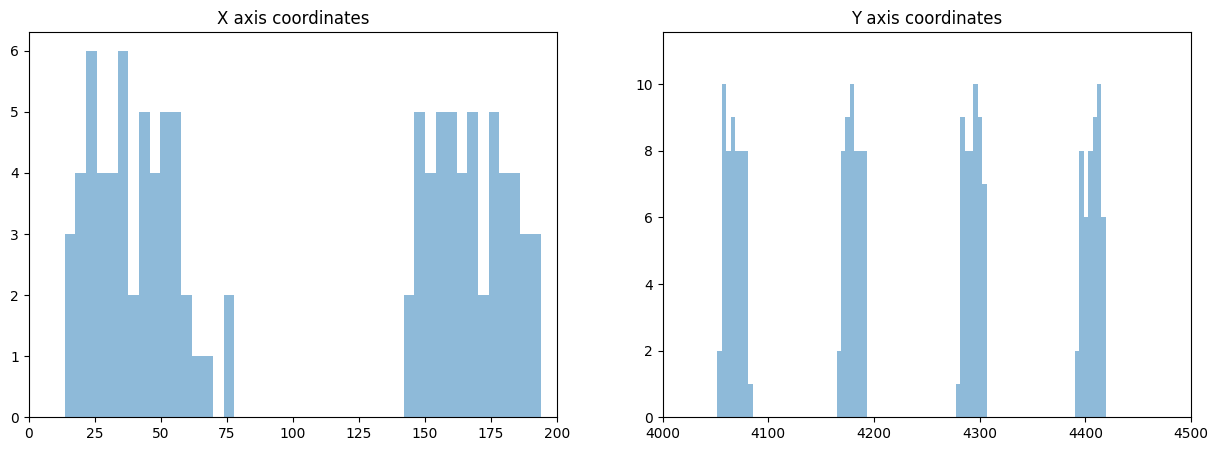

In [177]:

X = np.array([hex_i, hex_j])

rotation_delta_deg =  1
rotation_range = [-rotation_delta_deg* np.pi / 180, rotation_delta_deg * np.pi / 180]

n_plots = 1
fig,axs= plt.subplots(n_plots,2, sharex = False,squeeze = False, figsize = (15,5))
thetas = np.linspace(rotation_range[0], rotation_range[1], n_plots)
thetas = [0]
for i,theta in enumerate(thetas):
  R = rotation_matrix(theta)
  rotated = np.matmul(R,X)


  # plt.figure()
  # plt.scatter(*rotated, s = 0.5)
  # axs[i].plot(np.sort(rotated[0]))
  axs[i,0].hist(rotated[0], alpha = 0.5, bins = 2000)
  axs[i,1].hist(rotated[1], alpha = 0.5, bins = 2000)
  axs[i,0].set_xlim(0,200)
  axs[i,1].set_xlim(4000,4500)
  # axs[i].plot(np.fft.fft(rotated[0]))
  # plt.show()

axs[0,0].set_title('X axis coordinates')
axs[0,1].set_title('Y axis coordinates')


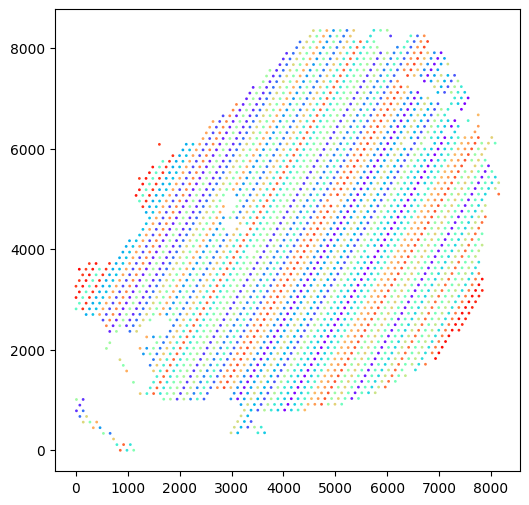

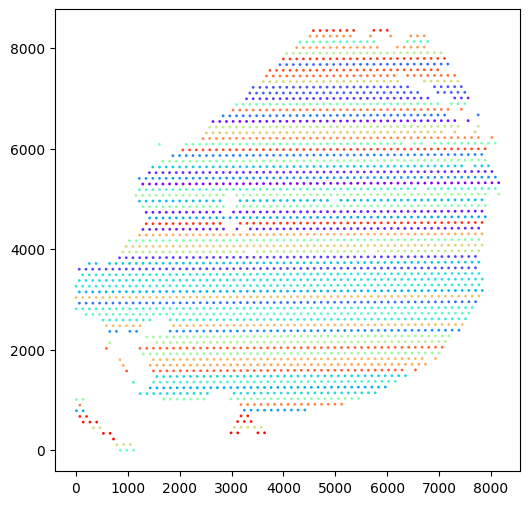

In [117]:
# Try using Hough transformation

# Convert to an image, our resolution is 1 pixel = 1 unit in x and y space

X = np.array([hex_i,hex_j])
coords=  X.astype(int)
xmin,xmax = np.min(coords[0]), np.max(coords[0])
ymin,ymax = np.min(coords[1]), np.max(coords[1])
width = np.floor(xmax - xmin).astype(int)
height = np.floor(ymax - ymin).astype(int)

coords[0] -= xmin
coords[1] -= ymin

image=  np.zeros((width + 1,height + 1))

for c in coords.T:
  image[c[0],c[1]] = 1




np.float64(1.0)

In [ ]:

tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(image2, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image2, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [
    np.rad2deg(theta[0] - angle_step),
    np.rad2deg(theta[-1] + angle_step),
    d[-1] + d_step,
    d[0] - d_step,
]
ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[2].axline((x0, y0), slope=np.tan(angle + np.pi / 2))

plt.tight_layout()
plt.show()

np.float64(113.22242959032499)

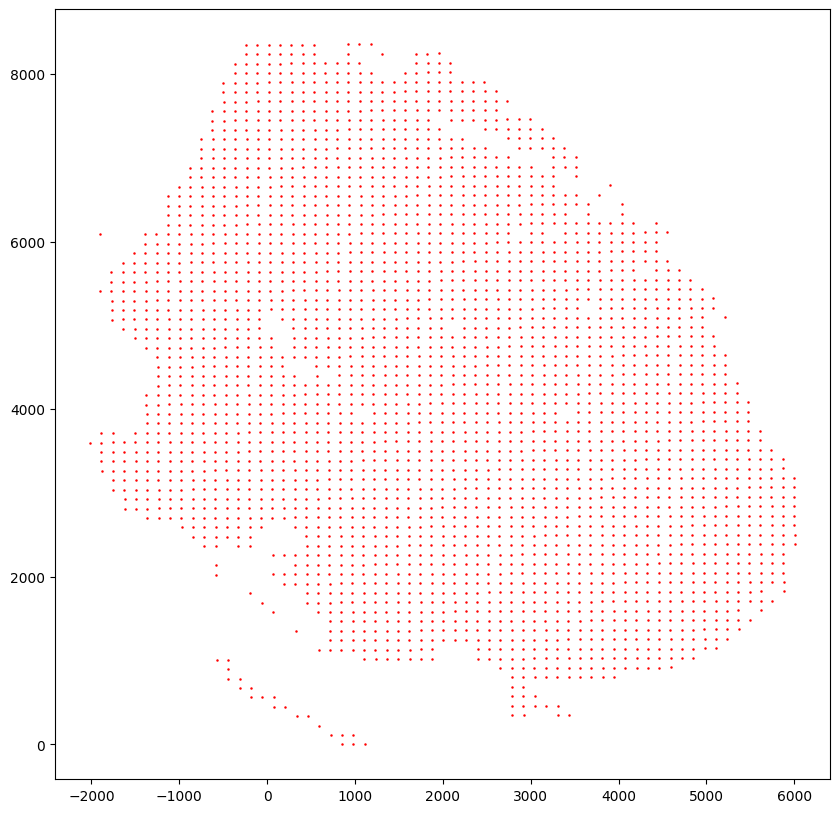

In [154]:
import numpy as np
import pandas as pd
import itertools
import math
import random
from statsmodels.formula.api import ols
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

def pt_line_dist(pt, ref_line):
    pt1, pt2 = [ref_line[:2], ref_line[2:]]
    # Distance from point to line defined by two other points
    return np.linalg.norm(np.cross(pt1 - pt2, [pt[0],pt[1]])) \
         / np.linalg.norm(pt1 - pt2)

def segment_pts(amts, grp_var, grp_label):
    # Segment on amounts (distances here) in last column of array
    # Note: need to label groups with string for OLS model
    amts = amts[amts[:, -1].argsort()]
    first_amt_in_grp = amts[0][-1]
    group, groups, grp = [], [], 0
    for amt in amts:
        if amt[-1] - first_amt_in_grp > grp_var:
            groups.append(group)
            first_amt_in_grp = amt[-1]
            group = []; grp += 1
        group.append(np.append(amt[:-1],[[grp_label + str(grp)]]))
    groups.append(group)
    return groups

def find_reference_line(pts):
    # Find point with minimum absolute slope relative both min y and max y
    y = np.hsplit(pts, 2)[1] # y column of array
    m = []
    for i, y_pt in enumerate([ pts[np.argmin(y)], pts[np.argmax(y)] ]):
        m.append(np.zeros((pts.shape[0]-1, 5))) # dtype default is float64
        m[i][:,2:4] = np.delete(pts, np.where((pts==y_pt).all(axis=1))[0], axis=0)
        m[i][:,4] = abs( (m[i][:,3]-y_pt[1]) / (m[i][:,2]-y_pt[0]) )
        m[i][:,:2] = y_pt
    m = np.vstack((m[0], m[1]))
    return m[np.argmin(m[:,4]), :4]

# Ignore division by zero (slopes of vertical lines)
np.seterr(divide='ignore')

# Create dataset and plot
pts = X.T
plt.figure(figsize = (10,10))
plt.scatter(pts[:,0], pts[:,1], c='r', s=0.6) # plot now because pts array changes

# Average distance to the nearest neighbor of each point
tree = KDTree(pts)
nn_avg_dist = np.mean(tree.query(pts, 2)[0][:, 1])

/tmp/ipython-input-818745004.py:13: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.linalg.norm(np.cross(pt1 - pt2, [pt[0],pt[1]])) \
/tmp/ipython-input-3087778628.py:26: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  df = pd.DataFrame(np.row_stack(groups), columns=['x', 'y', 'grp'])
/tmp/ipython-input-3087778628.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_lines['m'] = ols_model.params[-1] # slope


                      b r_grp           m
grp[o0]       -3.067717    o0    0.003459
grp[o1]      109.714836    o1    0.003459
grp[o10]    1126.015901    o1    0.003459
grp[o11]    1238.954349    o1    0.003459
grp[o12]    1351.836177    o1    0.003459
...                 ...   ...         ...
grp[r5]    35046.944869    r5 -289.069810
grp[r6]    56486.665605    r6 -289.069810
grp[r7]    79425.036553    r7 -289.069810
grp[r8]    93885.507337    r8 -289.069810
grp[r9]   121975.415081    r9 -289.069810

[122 rows x 3 columns]
     o_grp r_grp          o_b       o_m            r_b        r_m           x  \
0       o0    r0    -3.067717  0.003459   -2118.841733 -289.06981   -7.319162   
1       o0    r1    -3.067717  0.003459   -4639.451640 -289.06981  -16.038785   
2       o0    r1    -3.067717  0.003459   -4639.451640 -289.06981  -16.038785   
3       o0    r1    -3.067717  0.003459   -4639.451640 -289.06981  -16.038785   
4       o0    r1    -3.067717  0.003459   -4639.451640 -289.06981  

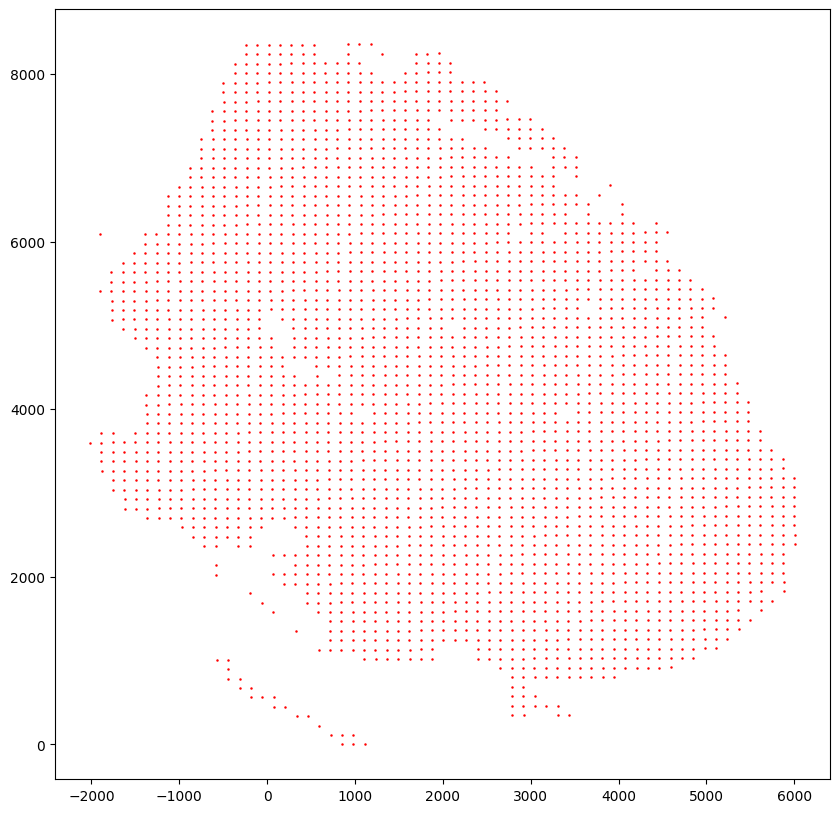

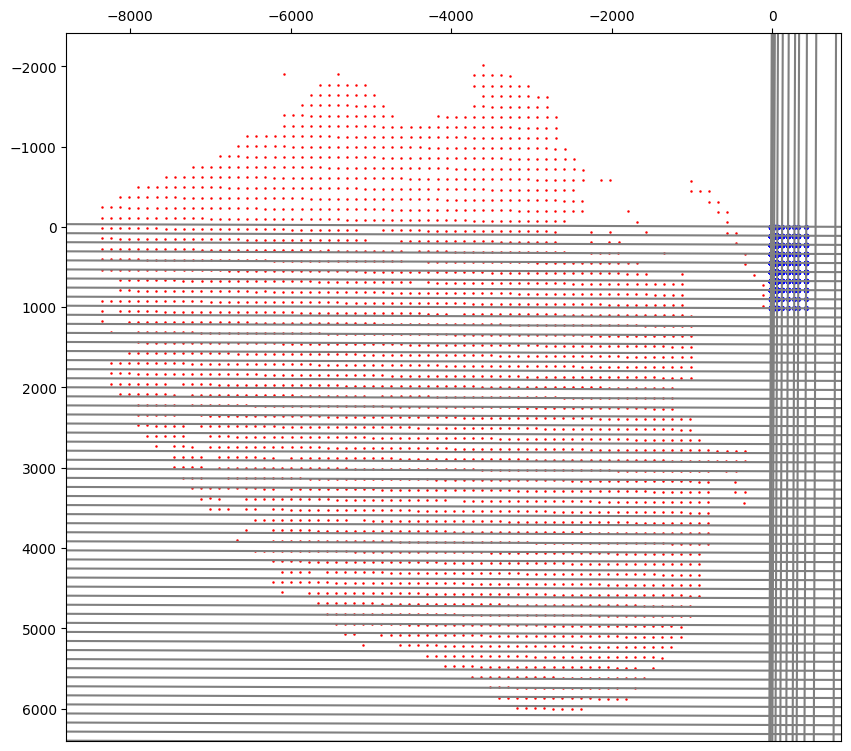

In [155]:

# Find groups of points representing each gridline
groups = []
for orientation in ['o', 'r']: #  original and rotated orientations

    # Rotate points 90 degrees (note: this moves pts to 2nd quadrant)
    if orientation == 'r':
        pts[:,1] = -1 * pts[:,1]
        pts[:, [1, 0]] = pts[:, [0, 1]]

    # Find reference line to compare remaining points for grouping
    ref_line = find_reference_line(pts) # line is defined by two points

    # Distances between points and reference line
    pt_dists = np.zeros((pts.shape[0], 3))
    pt_dists[:,:2] = pts
    pt_dists[:,2] = np.apply_along_axis(pt_line_dist, 1, pts, ref_line).T

    # Segment pts into groups w.r.t. distances (one group per gridline)
    # Groups have range less than nn_avg_dist.
    groups += segment_pts(pt_dists, 0.7*nn_avg_dist, orientation)

# Create dataframe of groups (OLS model requires a dataframe)
df = pd.DataFrame(np.row_stack(groups), columns=['x', 'y', 'grp'])
df['x'] = pd.to_numeric(df['x'])
df['y'] = pd.to_numeric(df['y'])

# Parallel slopes OLS model
ols_model = ols("y ~ x + grp + 0", data=df).fit()

# OLS parameters
grid_lines = ols_model.params[:-1].to_frame() # panda series to dataframe
grid_lines = grid_lines.rename(columns = {0:'b'})
grid_lines['grp'] = grid_lines.index.str[4:6]
grid_lines['m'] = ols_model.params[-1] # slope

# Rotate the rotated lines back to their original orientation
grid_lines.loc[grid_lines['grp'].str[0] == 'r', 'b'] = grid_lines['b'] / grid_lines['m']
grid_lines.loc[grid_lines['grp'].str[0] == 'r', 'm'] = -1 / grid_lines['m']

# Find grid intersection points by combinations of gridlines
comb = list(itertools.combinations(grid_lines['grp'], 2))
comb = [i for i in comb if i[0][0] != 'r']
comb = [i for i in comb if i[1][0] != 'o']
df_comb = pd.DataFrame(comb, columns=['grp', 'r_grp'])

# Merge gridline parameters with grid points
grid_pts = df_comb.merge(grid_lines.drop_duplicates('grp'),how='left',on='grp')
grid_lines.rename(columns={'grp': 'r_grp'}, inplace=True)
grid_pts.rename(columns={'b':'o_b', 'm': 'o_m', 'grp':'o_grp'}, inplace=True)
grid_pts = grid_pts.merge(grid_lines.drop_duplicates('r_grp'),how='left',on='r_grp')
grid_pts.rename(columns={'b':'r_b', 'm': 'r_m'}, inplace=True)

# Calculate x, y coordinates of gridline interception points
grid_pts['x'] = (grid_pts['r_b']-grid_pts['o_b']) \
              / (grid_pts['o_m']-grid_pts['r_m'])
grid_pts['y'] = grid_pts['o_m'] * grid_pts['x'] + grid_pts['o_b']

# Results output
print(grid_lines)
print(grid_pts)

plt.scatter(grid_pts['x'], grid_pts['y'], s=8, c='b') # for setting axes

axes = plt.gca()
axes.invert_yaxis()
axes.xaxis.tick_top()
axes.set_aspect('equal')
axes.set_xlim(axes.get_xlim())
axes.set_ylim(axes.get_ylim())

x_vals = np.array(axes.get_xlim())
for idx in grid_lines.index:
    y_vals = grid_lines['b'][idx] + grid_lines['m'][idx] * x_vals
    plt.plot(x_vals, y_vals, c='gray')

plt.show()